In [1]:
import os
import pandas as pd
import cv2
import torch
import torch.nn.utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from dataclasses import dataclass


In [2]:
@dataclass(frozen=True)
class DatasetConfig:
    SEED_VALUE:  int = 41
    CUT_PLANE:   str = "coronal"

    DATA_ROOT_TARGET:  str = f'/home/jovyan/data/segmentation/autopet-min-{CUT_PLANE}' 
    DATA_ROOT_TRAIN:  str = DATA_ROOT_TARGET + '/Train' 
    DATA_ROOT_VALID:  str = DATA_ROOT_TARGET + '/Valid'
    DATA_ROOT_TEST:   str = DATA_ROOT_TARGET + '/Test'
    DATA_TEST_GT:     str = DATA_ROOT_TARGET + '/Test.csv'

In [3]:
@dataclass(frozen=True)
class ImageResizeConfig:
    height: int = 1024
    width: int = 1024

In [4]:
# Prepare the training data list
# train_data = []

# images_file_names = os.listdir(DatasetConfig.DATA_ROOT_TRAIN+"/PET")

# images_dir = f'{DatasetConfig.DATA_ROOT_TRAIN}/PET/'
# masks_dir = f'{DatasetConfig.DATA_ROOT_TRAIN}/SEG/'

# for img_name in images_file_names:
#     if 'png' not in img_name:
#         continue
#     # Append image and corresponding mask paths
#     train_data.append({
#        "image": os.path.join(images_dir, img_name),
#        "annotation": os.path.join(masks_dir, img_name)
#     })

images_dir = f'{DatasetConfig.DATA_ROOT_TEST}/PET/'
masks_dir = f'{DatasetConfig.DATA_ROOT_TEST}/SEG/'

images_file_names = os.listdir(DatasetConfig.DATA_ROOT_TEST+"/PET")
# Prepare the testing data list (if needed for inference or evaluation later)
test_data = []
for img_name in images_file_names:
    if 'png' not in img_name:
        continue
    # Append image and corresponding mask paths
    test_data.append({
       "image": os.path.join(images_dir, img_name),
       "annotation": os.path.join(masks_dir, img_name)
    })

In [5]:
import random

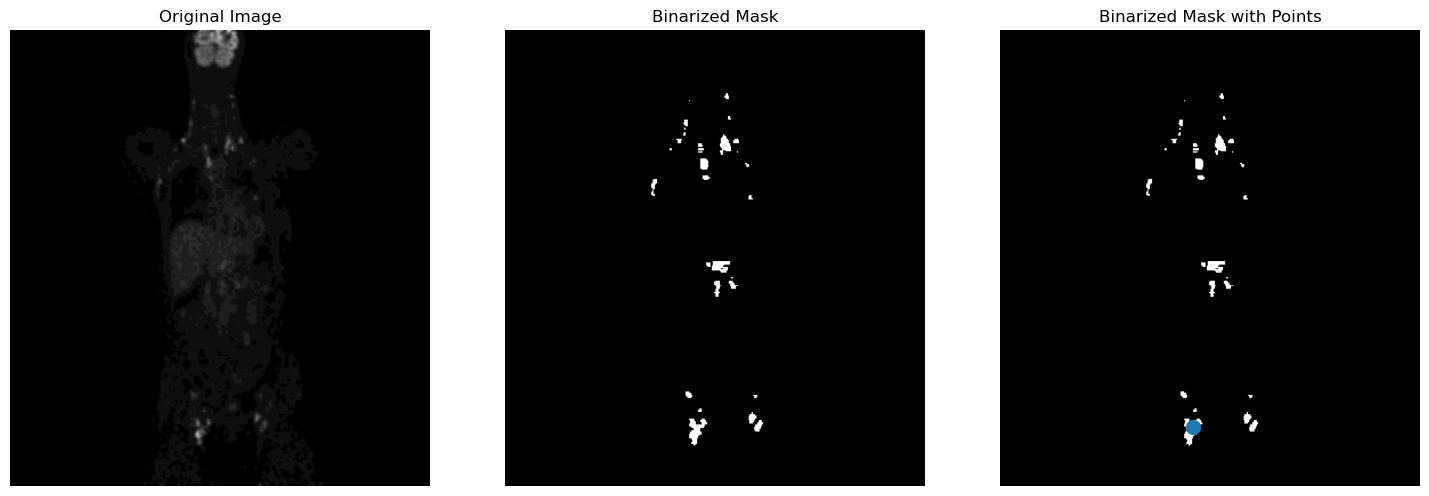

In [6]:
def read_batch(data, visualize_data=False):
    # Select a random entry
    ent = data[np.random.randint(len(data))]
    
    # Get full paths
    Img = cv2.imread(ent["image"])[..., ::-1]  # Convert BGR to RGB
    ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)  # Read annotation as grayscale
    
    if Img is None or ann_map is None:
       print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
       return None, None, None, 0
    
    # Resize image and mask
    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])  # Scaling factor
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
    
    
    ### Continuation of read_batch() ###
    
    # Initialize a single binary mask
    binary_mask = np.zeros_like(ann_map, dtype=np.uint8)
    points = []
    
    # Get binary masks and combine them into a single mask
    inds = np.unique(ann_map)[1:]  # Skip the background (index 0)
    for ind in inds:
       mask = (ann_map == ind).astype(np.uint8)  # Create binary mask for each unique index
       binary_mask = np.maximum(binary_mask, mask)  # Combine with the existing binary mask
    
    # Erode the combined binary mask to avoid boundary points
    eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)
    
    # Get all coordinates inside the eroded mask and choose a random point
    coords = np.argwhere(eroded_mask > 0)
    if len(coords) > 0:
       for _ in inds:  # Select as many points as there are unique labels
           yx = np.array(coords[np.random.randint(len(coords))])
           points.append([yx[1], yx[0]])
    
    points = np.array(points)

    if visualize_data:
        # Plotting the images and points
        plt.figure(figsize=(15, 5))
    
        # Original Image
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(Img)
        plt.axis('off')
    
        # Segmentation Mask (binary_mask)
        plt.subplot(1, 3, 2)
        plt.title('Binarized Mask')
        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')
    
        # Mask with Points in Different Colors
        plt.subplot(1, 3, 3)
        plt.title('Binarized Mask with Points')
        plt.imshow(binary_mask, cmap='gray')
    
        # Plot points in different colors
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i, point in enumerate(points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=100, label=f'Point {i+1}')  # Corrected to plot y, x order
    
        # plt.legend()
        plt.axis('off')
    
        plt.tight_layout()
        plt.show()
    
    binary_mask = np.expand_dims(binary_mask, axis=-1)  # Now shape is (1024, 1024, 1)
    binary_mask = binary_mask.transpose((2, 0, 1))
    points = np.expand_dims(points, axis=1)
    
    # Return the image, binarized mask, points, and number of masks
    return Img, binary_mask, points, len(inds)
    
# Visualize the data
Img1, masks1, points1, num_masks = read_batch(test_data, visualize_data=True)

In [7]:
def read_image(image_path, mask_path):  # read and resize image and mask
   img = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
   mask = cv2.imread(mask_path, 0)
   r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
   img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
   mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
   return img, mask

def get_points(mask, num_points):  # Sample points inside the input mask
   points = []
   coords = np.argwhere(mask > 0)
   for i in range(num_points):
       yx = np.array(coords[np.random.randint(len(coords))])
       points.append([[yx[1], yx[0]]])
   return np.array(points)

In [8]:
def calc_iou_bbox(box1, box2):
    x1,y1,x2,y2 = box1
    x3,y3,x4,y4 = box2
    x_inter1 = max(x1,x3)
    y_inter1 = max(y1,y3)
    x_inter2 = min(x2,x4)
    y_inter2 = min(y2,y4)
    width_inter = abs(x_inter2-x_inter1)
    height_inter = abs(y_inter2-y_inter1)
    area_inter= width_inter * height_inter
    width_box1 = abs(x2-x1)
    height_box1 = abs(y2-y1)
    width_box2 = abs(x4-x3)
    height_box2 = abs(y4-y3)
    area_box1 = width_box1 * height_box1
    area_box2 = width_box2 * height_box2
    area_union = area_box1 + area_box2 - area_inter
    iou = area_inter / area_union
    return iou

In [9]:
def calc_dice_bbox(box1, box2):
    x1,y1,x2,y2 = box1
    x3,y3,x4,y4 = box2
    x_inter1 = max(x1,x3)
    y_inter1 = max(y1,y3)
    x_inter2 = min(x2,x4)
    y_inter2 = min(y2,y4)
    width_inter = abs(x_inter2-x_inter1)
    height_inter = abs(y_inter2-y_inter1)
    area_inter= width_inter * height_inter
    width_box1 = abs(x2-x1)
    height_box1 = abs(y2-y1)
    width_box2 = abs(x4-x3)
    height_box2 = abs(y4-y3)
    area_box1 = width_box1 * height_box1
    area_box2 = width_box2 * height_box2
    area_union = area_box1 + area_box2 - area_inter
    iou = area_inter / area_union
    return (2 * area_inter)/(area_box1 + area_box2)

In [10]:
#Get bounding boxes from mask.
def get_bounding_box(mask):
  # get bounding box from mask
  y_indices, x_indices = np.where(mask > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  # H, W = mask.shape
  # x_min = max(0, x_min - np.random.randint(0, 20))
  # x_max = min(W, x_max + np.random.randint(0, 20))
  # y_min = max(0, y_min - np.random.randint(0, 20))
  # y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

/opt/conda/lib/python3.11/site-packages/sam2/modeling/sam/transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:723.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/opt/conda/lib/python3.11/site-packages/sam2/modeling/sam/transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at ../aten/src/ATen/native/transformers/sdp_utils_cpp.h:495.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/opt/conda/lib/python3.11/site-packages/sam2/modeling/sam/transformer.py:270: UserWarning: Flash attention kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:725.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/opt/conda/lib/python3.11/site-packages/sam2/modeling/sam/transformer.py:270: UserWarning: Expected query, key and value to a

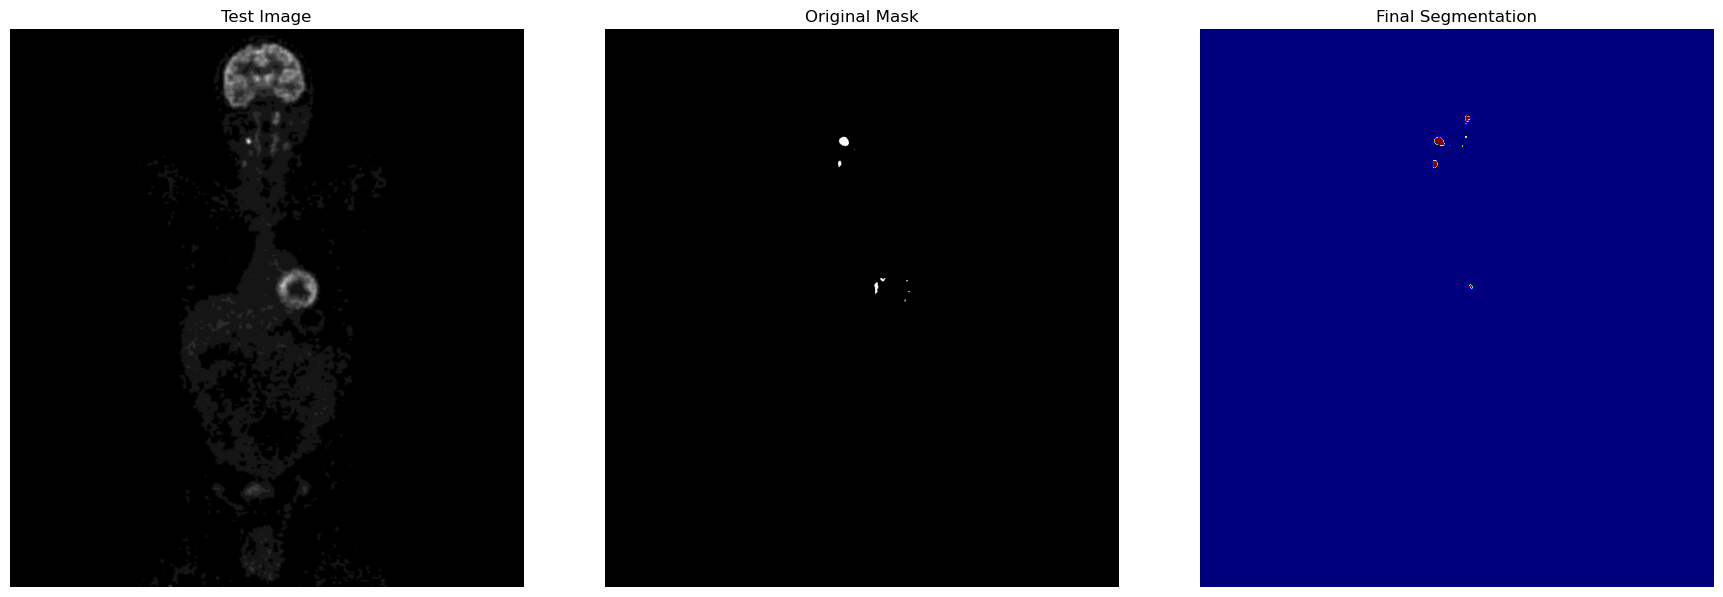

In [11]:
# Randomly select a test image from the test_data
selected_entry = random.choice(test_data)
image_path = selected_entry['image']
mask_path = selected_entry['annotation']

# Load the selected image and mask
image, mask = read_image(image_path, mask_path)

# Generate random points for the input
num_samples = 30  # Number of points per segment to sample
input_points = get_points(mask, num_samples)

# Load the fine-tuned model
FINE_TUNED_MODEL_WEIGHTS = "./checkpoints/fine_tuned_sam2-coronal_1500.torch"
model_cfg = "sam2_hiera_l.yaml"
sam2_checkpoint = "sam2_hiera_large.pt"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

# Build net and load weights
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))

# Perform inference and predict masks
with torch.no_grad():
   predictor.set_image(image)
   masks, scores, logits = predictor.predict(
       point_coords=input_points,
       point_labels=np.ones([input_points.shape[0], 1])
   )

# Process the predicted masks and sort by scores
np_masks = np.array(masks[:, 0])
np_scores = scores[:, 0]
sorted_masks = np_masks[np.argsort(np_scores)][::-1]

# Initialize segmentation map and occupancy mask
seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)

# Combine masks to create the final segmentation map
for i in range(sorted_masks.shape[0]):
   mask = sorted_masks[i]
   if (mask * occupancy_mask).sum() / mask.sum() > 0.15:
       continue

   mask_bool = mask.astype(bool)
   mask_bool[occupancy_mask] = False  # Set overlapping areas to False in the mask
   seg_map[mask_bool] = i + 1  # Use boolean mask to index seg_map
   occupancy_mask[mask_bool] = True  # Update occupancy_mask

# Visualization: Show the original image, mask, and final segmentation side by side
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Test Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Original Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Final Segmentation')
plt.imshow(seg_map, cmap='jet')
plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
gt_mask = get_bounding_box(mask)
gt_mask

[427, 198, 558, 499]

In [13]:
pred_mask = get_bounding_box(seg_map)
pred_mask

[427, 159, 499, 476]

In [14]:
calc_iou_bbox(gt_mask, pred_mask)

0.4738748549918322

In [15]:
calc_dice_bbox(gt_mask, pred_mask)

0.643032688137499

In [16]:
mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
seg_map_copy = seg_map
seg_map_copy[seg_map_copy>0] = 1

In [18]:
from sklearn.metrics import f1_score, jaccard_score

# same as DICE Score
print("DICE: " + str(f1_score(mask.flatten(), seg_map_copy.flatten())))
print("IOU: " + str(jaccard_score(mask.flatten(), seg_map_copy.flatten())))

DICE: 0.6749716874292185
IOU: 0.5094017094017094


In [19]:
from tqdm import tqdm

In [20]:
def process_test_set(data, fine_tuned_model_weights, inference_batch = 10):
    images = []
    annotations = []
    input_points_list = []
    point_labels = []
    
    for record in data:
        image, mask = read_image(record["image"], record["annotation"])
        num_samples = 30  # Number of points per segment to sample
        input_points = get_points(mask, num_samples)
        images.append(image)
        annotations.append(mask)
        input_points_list.append(input_points)
        point_labels.append(np.ones([input_points.shape[0], 1]))

    pred_masks = []
    images_chunks = [images[x:x+inference_batch] for x in range(0, len(images), inference_batch)]
    annotations_chunks = [annotations[x:x+inference_batch] for x in range(0, len(annotations), inference_batch)]
    input_points_chunks = [input_points_list[x:x+inference_batch] for x in range(0, len(input_points_list), inference_batch)]
    point_labels_chunks = [point_labels[x:x+inference_batch] for x in range(0, len(point_labels), inference_batch)]

    # Load the fine-tuned model
    # FINE_TUNED_MODEL_WEIGHTS = "./checkpoints/fine_tuned_sam2_1500.torch"
    model_cfg = "sam2_hiera_l.yaml"
    sam2_checkpoint = "sam2_hiera_large.pt"
    sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

    # Build net and load weights
    predictor = SAM2ImagePredictor(sam2_model)
    predictor.model.load_state_dict(torch.load(fine_tuned_model_weights))

    for i in tqdm(range(len(images_chunks)), total=len(images_chunks)):
        # Perform batch inference and predict masks
        with torch.no_grad():
            predictor.set_image_batch(images_chunks[i])
            masks, scores, logits = predictor.predict_batch(
               point_coords_batch=input_points_chunks[i],
               point_labels_batch=point_labels_chunks[i]
            )
            
            pred_masks.append(process_masks(masks))
            # pred_masks = np.concatenate((pred_masks, process_masks(masks)))

    #flatten the pred_masks
    flat_pred_masks = [item for sublist in pred_masks for item in sublist]
            
    return flat_pred_masks, annotations, images

In [21]:
def process_masks(masks):
    seg_maps = []
    for mask_records in masks:
        # Process the predicted masks and sort by scores
        np_masks = np.array(mask_records[:, 0])
        np_scores = scores[:, 0]
        sorted_masks = np_masks[np.argsort(np_scores)][::-1]
        
        # Initialize segmentation map and occupancy mask
        seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
        occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)
        
        # Combine masks to create the final segmentation map
        for i in range(sorted_masks.shape[0]):
           mask = sorted_masks[i]
           if (mask * occupancy_mask).sum() / mask.sum() > 0.15:
               continue
        
           mask_bool = mask.astype(bool)
           mask_bool[occupancy_mask] = False  # Set overlapping areas to False in the mask
           seg_map[mask_bool] = i + 1  # Use boolean mask to index seg_map
           occupancy_mask[mask_bool] = True  # Update occupancy_mask

        seg_maps.append(seg_map)
        
    return np.array(seg_maps)

In [22]:
def show_record(pred_mask, true_mask, image):
    # Visualization: Show the original image, mask, and final segmentation side by side
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.title('Test Image')
    plt.imshow(image)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title('Original Mask')
    plt.imshow(true_mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title('Final Segmentation')
    plt.imshow(pred_mask, cmap='jet')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [23]:
FINE_TUNED_MODEL_WEIGHTS = "./checkpoints/fine_tuned_sam2-coronal_1500.torch"

In [24]:
pred_masks, true_masks, images = process_test_set(test_data, FINE_TUNED_MODEL_WEIGHTS)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.94s/it]


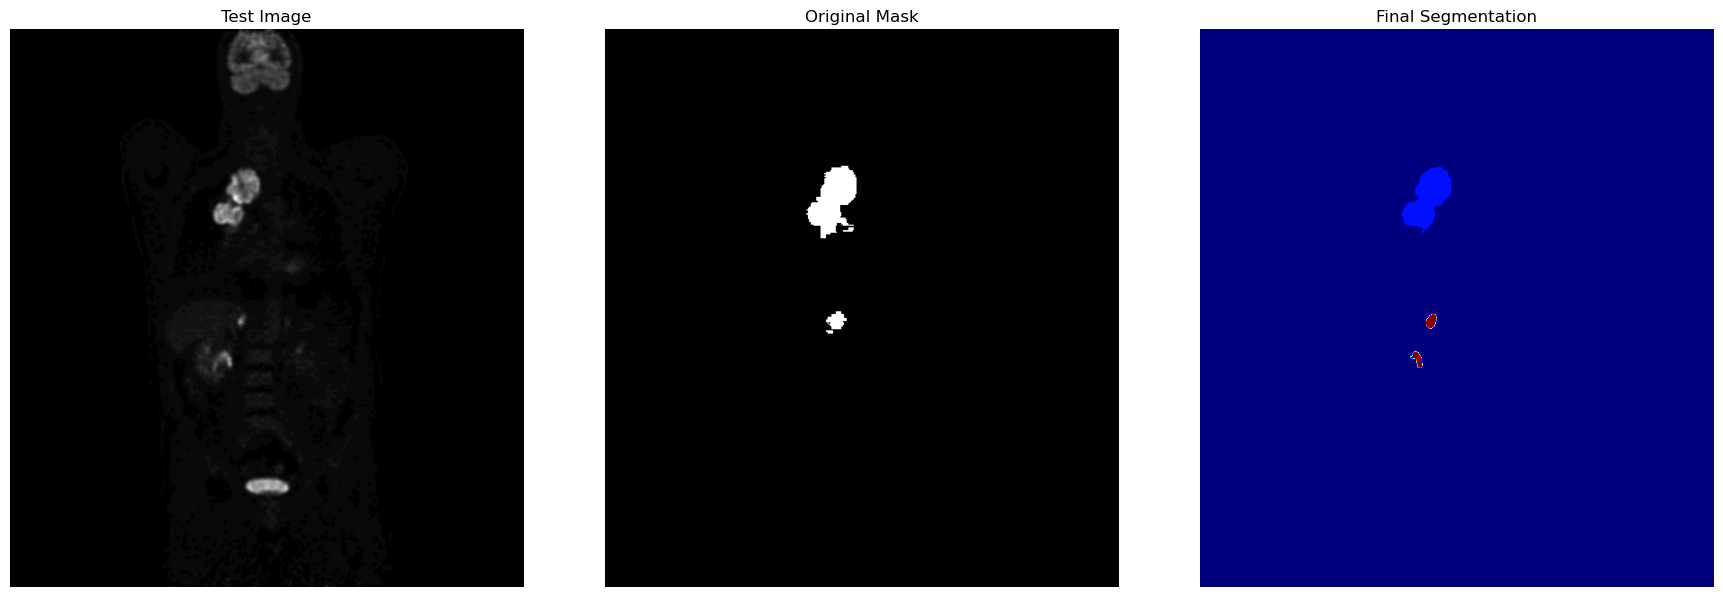

In [25]:
random_index = random.randrange(len(test_data))
show_record(pred_masks[random_index], true_masks[random_index], images[random_index])

In [26]:
dice_metric = []
iou_metric = []

for i in tqdm(range(len(images)), total=len(images)):
    seg_map_copy = pred_masks[i]
    seg_map_copy[seg_map_copy>0] = 1
    
    gt_mask = true_masks[i]
    gt_mask[gt_mask>0] = 1
    
    dice_metric.append(f1_score(gt_mask.flatten(), seg_map_copy.flatten()))
    iou_metric.append(jaccard_score(gt_mask.flatten(), seg_map_copy.flatten()))

print("DICE: " + str(np.array(dice_metric).mean()))
print("IOU: " + str(np.array(iou_metric).mean()))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:24<00:00,  3.47it/s]

DICE: 0.7041793534495696
IOU: 0.5753272992312662
